Title: Intro to Multithreading and Multiprocessing
Slug: intro-multithreading-and-multiprocessing
Summary: Use multithreading and multiprocessing as options for parallel programming in Python to perform tasks at the same time 
Date: 2018-04-25 12:00  
Category: Python 
Subcategory: Intermediate Concepts
Tags: multithreading multiprocessing
Keywords: multithreading multiprocessing tutorial python
Authors: Dan Friedman

### Why is Performant Code Important

In analyzing data, you may be dealing with thousands, millions or even billions of records. As you perform computations to gain insights, you'll likely do lots of data transformations.

With each computation, to save even seconds or minutes can be greatly helpful for you to deliver insights to your team faster and ultimately get more work done over time.

With parallel programming in Python, you can do just that.

### Brief Overview

#### Intro to Parallelism

**Parallelism** (aka parallel programming) is when two or more tasks run *at the same time*. There's important terminology to understand regarding parallelism too.

A **thread** is an execution context for code.

A **process** is a program and state of all threads executing in a program.

One process can have several threads running *at the same time*. One program could also have several proccess running *at the same time*.

In Python, by default programs run as a single process with a single thread of execution; this uses just a single CPU. 

Examples parallelism can help with:

- executing database queries
- pre-processing lots of images to use for machine learning
- web crawling 

#### CPU & Core

The CPU (central processing unit) manages the computational work of the computer. CPUs have one or more cores which allow for code to be executed simultaneously. 

My Macbook Pro has 4 cores.

A single core can perform a number of computations in a limited amount of time. However, if a Python program uses another process running on another core, we greatly decrease the program's runtime.

#### Python's Global Interpreter Lock

CPython (the standard python implementation) has something called the GIL (Global Interpreter Lock); the GIL prevents two threads from executing simultaneously in the same program. However, two threads can run concurrently and one can run code while another may be waiting.

The GIL limits parallel programming in Python out of the box.

#### When to use threads versus processes

**Threads** are typically best for IO tasks or tasks involving external systems since threads work well to combine results quickly. On the other hand, processes need to pickle their results and therefore take more time to combine results from multiple processes.

**Threads** provide no benefit for expensive CPU tasks since threads must run within the GIL.

**Multiple processes** can speed up Python operations that are CPU intensive because they can utilize multiple cores and avoid Python's GIL.

### `map` Function and Example

The use of `map` will be applied in our parallel programming examples later; so I'll provide a brief introduction now.

Below I wrote a function called `number_times_two` to take in a number, multiply it by two and return the result.

`map` is a built-in Python function that helps us easily apply a function over every item in an iterable such as a list. 

We'll use the `map` function to apply `number_times_two` to every element in the list of numbers `[1, 2, 3, 4]`.

This table illustrates the operations that will take place.

Input | number_times_two Operation | Result
--- | --- | ---
1 | 1*2 | 2
2 | 2*2 | 4
3 | 3*2 | 6
4 | 4*2 | 8




In [55]:
def number_times_two(number):
    """
    Multiply a number by 2
    
    :param number: a value we'll use in our computation
    :type number: (preferably an) int
    
    :returns: number*2
    """
    return number*2

In [56]:
type(number_times_two)

function

The `map` function returns an *map object* that is an *iterator*.

In [57]:
map(number_times_two, [1, 2, 3, 4])

We can call the built-in `list` function to output our result, the *map* object, as a list.

In [58]:
list(map(number_times_two, [1, 2, 3, 4]))

[2, 4, 6, 8]

### Parallelism

#### Import Modules

In [59]:
from requests import get
from multiprocessing.dummy import Pool as ThreadPool 
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from time import time
from random import sample
import numpy as np
%matplotlib inline

#### Helper Functions

These functions below will help us visually illustrate the effect of multithreading so it's easier to understand.

In [60]:
def multithreading(function, iterable, number_of_threads):
    """
    Maps a function across an iterable (such as a list of elements) with the optional use of multithreading.
    
    :param function: name of a function
    :type function: function
    
    :param iterable: elements used as inputs to function parameter
    :type iterable: list
    
    :param number_of_threads: number of threads to use in map operation
    :type number_of_threads: int
    
    :returns list_objects: return objects from our function parameter calls
    :return type: list
    """    
    with ThreadPoolExecutor(max_workers=number_of_threads) as executor:
        responses = executor.map(function, iterable)
    return list(responses)

In [61]:
def do_multiprocessing(function, iterable, number_of_concurrent_processes):
    """
    Maps a function across an iterable (such as a list of elements) with the optional use of multiprocessing.
    
    :param function: name of a function
    :type function: function
    
    :param iterable: elements used as inputs to function parameter
    :type iterable: list
    
    :param number_of_concurrent_processes: number of concurrent processes in multiprocessing
    :type number_of_concurrent_processes: int
    
    :returns list_objects: return objects from our function parameter calls
    :return type: list
    """    
    with ProcessPoolExecutor(max_workers=number_of_concurrent_processes) as executor:
        responses = executor.map(function, iterable)
    return list(responses)

In [62]:
def transform_timestamps_to_be_seconds_from_process_start_time(process_start_time, all_task_timestamps):
    """
    Take list of start and end timestamps of # of seconds since epoch, and subtract the process start time from them all
    
    Therefore we'll know how far timestamps are from the 0th second, the start of the program.
    
    :param process_start_time: # of seconds since epoch for start of task
    :type process_start_time: float
    
    :param all_task_timestamps: # of seconds since epoch for end of task
    :type all_task_timestamps: list
    
    :return function_timestamps_starting_from_zero: same shape as all_task_timestamps but all values subtracted by process_start_time
    :type function_timestamps_starting_from_zero: numpy array
    """
    function_timestamps_starting_from_zero = np.array(all_task_timestamps) - process_start_time
    return function_timestamps_starting_from_zero

In [63]:
def separate_list_elements(list_of_lists):
    """
    Given a list structure such as [[x, y], [x, y]] return a list of just the x's and another of just y's
    
    :param list_of_lists: list with nested lists
    :type list_of_list: list
    
    :return start_values, end_values: two lists - one of all 0-th index values and another of 1st index values in each nested list
    :return type: tuple storing two lists
    """
    start_values = [inner_list[0] for inner_list in list_of_lists]
    start_values = np.array(start_values)
    
    end_values = [inner_list[1] for inner_list in list_of_lists]
    end_values = np.array(end_values)
    return start_values, end_values

In [64]:
def generate_bar_colors(number_of_threads_or_subprocesses):
    """
    Make a list of colors the same length as the number of threads or number of concurrent subprocesses
    
    :param number_of_threads_or_subprocesses: number of threads used in multithreading or number of processes used in multiprocessing
    :type number_of_threads_or_subprocesses: int
    
    :return colors: list of colors chosen from good_colors
    :type colors: list
    """
    good_colors = ['firebrick', 'darkgreen', 'royalblue', 'rebeccapurple', 'dimgrey', 'teal', 'chocolate', 'darkgoldenrod']
    colors = sample(good_colors, number_of_threads_or_subprocesses)
    return colors

In [65]:
def visualize_task_times(start_times, end_times, plot_title, colors):
    """
    Use Matplotlib module to create a horizontal bar chart of the time elapsed for each task.
    
    :param start_times: start times of tasks
    :type start_times: list
    
    :param end_times: end times of tasks
    :type end_times: list
    
    :param plot_title: title of plot
    :type plot_title: string
    
    :param colors: colors of bars
    :type colors: list
    
    :return: None
    """
    plt.barh(range(len(start_times)), end_times-start_times, left=start_times, color=colors);
    plt.grid(axis='x');
    plt.ylabel("Tasks");
    plt.xlabel("Seconds");
    plt.title(plot_title);
    plt.figure(figsize=(12, 10));
    plt.show();
    return None;

In [66]:
def visualize_multiprocessing_effect(number_of_concurrent_processes, function_name, iterable, plot_title):
    """
    Perform multithreading given a function_name and number_of_threads and visualize tasks as bar chart
    
    :param number_of_concurrent_processes: number of concurrent processes in multiprocessing
    :type number_of_concurrent_processes: int
    
    :param function_name: name of function applied in multithreading operation
    :type function_name: function
    
    :param iterable: elements used as inputs to function parameter
    :type iterable: list
    
    :param plot_title: title of plot
    :type plot_title: string
    
    :return: None
    """
    process_start_time = time() # we track time here 
    time_logs_multiprocessing_op = do_multiprocessing(function_name, iterable, number_of_concurrent_processes)
    multiprocessing_task_timestamps = transform_timestamps_to_be_seconds_from_process_start_time(process_start_time, time_logs_multiprocessing_op)
    start_times, end_times = separate_list_elements(multiprocessing_task_timestamps)
    colors = generate_bar_colors(number_of_concurrent_processes)
    visualize_task_times(start_times, end_times, plot_title, colors)

In [67]:
def visualize_multithreading_effect(number_of_threads, function_name, iterable, plot_title):
    """
    Perform multithreading given a function_name and number_of_threads and visualize tasks as bar chart
    
    :param number_of_threads: number of threads used in multithreading
    :type number_of_threads: int
    
    :param function_name: name of function applied in multithreading operation
    :type function_name: function
    
    :param iterable: elements used as inputs to function parameter
    :type iterable: list
    
    :param plot_title: title of plot
    :type plot_title: string
    
    :return: None
    """
    process_start_time = time() # we track time here 
    time_logs_multithreading_op = multithreading(function_name, iterable, number_of_threads)
    multithreading_task_timestamps = transform_timestamps_to_be_seconds_from_process_start_time(process_start_time, time_logs_multithreading_op)
    start_times, end_times = separate_list_elements(multithreading_task_timestamps)
    colors = generate_bar_colors(number_of_threads)
    visualize_task_times(start_times, end_times, plot_title, colors)

### Measure Server Response Times

This is a popular example on the web. For a long list of URLs, we'll use the `requests` module to `get` a *response object*. 

With this *response object*, we could later perform operations to see the status of the request, get the contents of the site and more!

In [68]:
twelve_urls = ['https://secure.capitalbikeshare.com/map/']*16

In [69]:
def get_response_time_measurements(url):
    """
    mark start time, then call the get method and pass in a url to receive a server response object, then mark end time
    
    :param url: address of a worldwide web page 
    :type url: string
    
    :returns: start_time and stop_time of this task
    :type returns: list
    """
    start_time = time()
    try:
        response = get(url)
    except Exception as exception_object:
        print('Error with request for url: {0}'.format(url))
    stop_time = time()
    return [start_time, stop_time]

First, just to illustrate our `multithreading` function, I'll call the `multithreading` function relevant to this example.

We'll be return a list of nested lists, in which each nested list will contain the start timestamp and end timestamp of each task - each task being getting a new server response.

In [70]:
multithreading(function=get_response_time_measurements, iterable=twelve_urls, number_of_threads=1)

[[1524632208.212652, 1524632209.3562171],
 [1524632209.356304, 1524632210.377363],
 [1524632210.377422, 1524632211.401835],
 [1524632211.401959, 1524632212.424235],
 [1524632212.424294, 1524632213.458614],
 [1524632213.458688, 1524632214.472278],
 [1524632214.4723809, 1524632215.3774521],
 [1524632215.377533, 1524632216.250168],
 [1524632216.250221, 1524632217.121071],
 [1524632217.1211221, 1524632218.161929],
 [1524632218.1619892, 1524632219.187152],
 [1524632219.187215, 1524632220.207478],
 [1524632220.207537, 1524632221.231024],
 [1524632221.231082, 1524632222.255033],
 [1524632222.255092, 1524632223.084519],
 [1524632223.084579, 1524632223.900953]]

#### Multithreading with 1 Thread

In the visualizations below, each color represents the use of one thread in the operations. 

So for multithreading with two threads, you'll see two color bars, one for each thread.

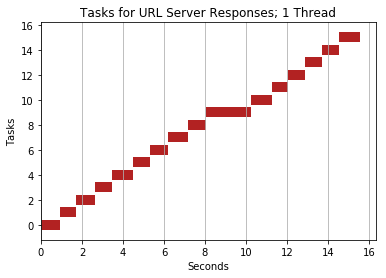

In [71]:
visualize_multithreading_effect(number_of_threads=1,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 1 Thread")

#### Multithreading with 2 Threads

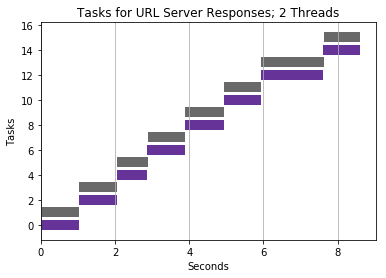

In [72]:
visualize_multithreading_effect(number_of_threads=2,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 2 Threads")

Let's visualize the effect of multithreading with 4 threads.

#### Multithreading with 4 Threads

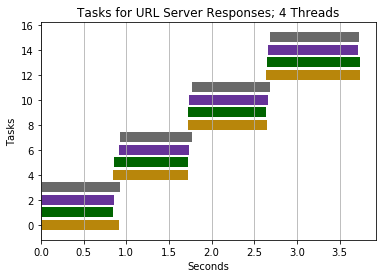

In [73]:
visualize_multithreading_effect(number_of_threads=4,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 4 Threads")

#### Multithreading with 8 Threads

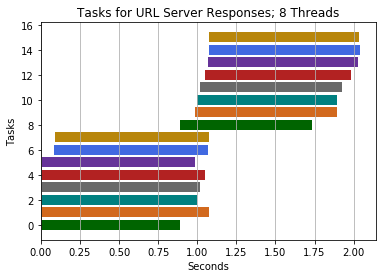

In [74]:
visualize_multithreading_effect(number_of_threads=8,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 8 Threads")

#### Multiprocessing with 1 Process

In the visualizations below, each color represents the use of one process in the operations. 

So for multiprocessing with two concurrent processes, you'll see two color bars, one for each process.

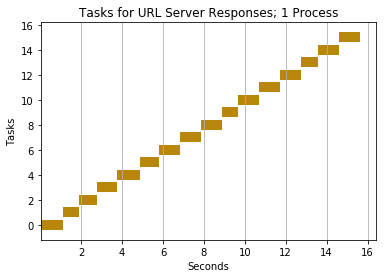

In [75]:
visualize_multiprocessing_effect(number_of_concurrent_processes=1,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 1 Process")

#### Multiprocessing with 2 Processes

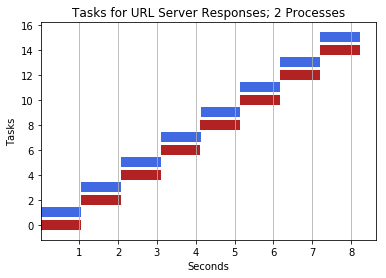

In [76]:
visualize_multiprocessing_effect(number_of_concurrent_processes=2,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 2 Processes")

Let's visualize the effect of multiprocessing with 4 concurrent processes.

#### Multiprocessing with 4 Processes

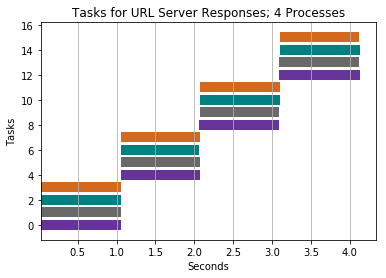

In [77]:
visualize_multiprocessing_effect(number_of_concurrent_processes=4,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 4 Processes")

Let's visualize the effect of multiprocessing with 8 concurrent processes.

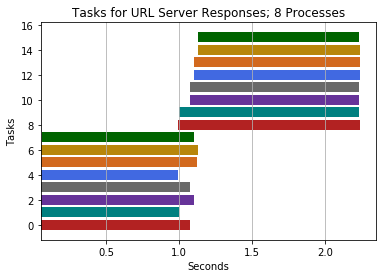

In [79]:
visualize_multiprocessing_effect(number_of_concurrent_processes=8,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 8 Processes")

#### Single Process and Thread

Now, let's perform the same operation **without** the overhead of setting up multithreading.

In [80]:
%%time

# traditional python program without multithreading
task_timestamps = list(map(get_response_time_measurements, twelve_urls));

CPU times: user 410 ms, sys: 28.4 ms, total: 438 ms
Wall time: 16 s


**Conclusion:** both multithreading and multiprocessing complete much quicker than a single thread & program.

The reason parallel programming is much faster here is because the processor isn't working very hard to retreive the contents on the sites; however, the bottleneck is waiting for the site's server response to our HTTP request - an external resource. While one task is performing an operation of getting/waiting for a server response for one URL, another task can start for a different URL. 

Threads are also fairly quick to combine their results too. So if we were web crawling and constantly wanted to combine results from multiple crawlers, it'd be ideal to use multiple threads to spawn multiple web crawlers rather than multiple processes which take longer to combine results.

### Example: Squares of Numbers

Given this big list of numbers in `big_list`, we want to output a new list that has the square of all numbers in `big_list`.

Think of this as a *lot* of *small* operations.

In [81]:
big_list = range(1, 12000000)

In [82]:
def square_value(x):
    return x**2

#### Multithreading

Below I utilize code from another module of the Python standard library, `multiprocessing`, to perform multithreading for this operation. 

By default, we will use all available threads on our computer.

In [83]:
%%time

pool = ThreadPool() 

squares_pool_results = pool.map(square_value, big_list)

pool.close()
pool.join()

CPU times: user 5.51 s, sys: 715 ms, total: 6.23 s
Wall time: 6.2 s


#### Multiprocessing

Below I utilize code from the lower-level module of the Python standard library, `multiprocessing`, to perform multiprocessing for this operation. 

We'll use 2 concurrent processes.

In [84]:
%%time

with Pool(processes=2) as multiprocessing_operation:
    multiprocessing_operation.map(square_value, big_list)

CPU times: user 2.04 s, sys: 947 ms, total: 2.99 s
Wall time: 4.84 s


#### Single Process & Thread

In [85]:
%%time
    
squares_results = map(square_value, big_list)

CPU times: user 13 µs, sys: 8 µs, total: 21 µs
Wall time: 26 µs


**Conclusion:** process completes much faster *without* parallel programming.

This may come as a surprise that parallel programming hurts our performance here.

Using parallel programming in Python or any other interpreted language with a global interpreter lock (GIL) can actually result in reduced performance if you're *just* doing a CPU bound task. This program must carry parallel programming's additional overhead of creating new threads or processes and synchronizing their results. 

### Example: CPU Heavy Computations

In this example, we'll only perform 8 tasks - with each task requiring a large amount of math operations.

In [86]:
def sum_all_intgers_from_zero_to_end_range_number(end_range_number):
    """
    Calculate the sum of all integer numbers from 0 to end_range_number. 
    
    :param end_range_number: highest value to loop over
    :type end_range_number: integer
    
    :returns [start_time, stop_time]: list of start_time of task and end time of task
    :return type: list
    """
    start_time = time()
    the_sum = 0
    for number in range(0, end_range_number):
        the_sum += number
    stop_time = time()
    return [start_time, stop_time]

In [87]:
large_number = 11**7
iterations = 8

In [88]:
large_numbers = [large_number]*iterations

In [89]:
large_numbers

[19487171,
 19487171,
 19487171,
 19487171,
 19487171,
 19487171,
 19487171,
 19487171]

#### Multithreading

Let's visualize the effect of multithreading with 2 concurrent threads.

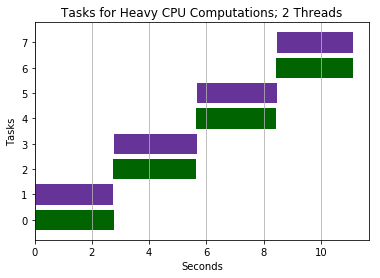

In [95]:
visualize_multithreading_effect(number_of_threads=2,
                                function_name=sum_all_intgers_from_zero_to_end_range_number,
                                iterable=large_numbers,
                                plot_title="Tasks for Heavy CPU Computations; 2 Threads")

#### Multiprocessing

Let's visualize the effect of multiprocessing with 2 concurrent subprocesses.

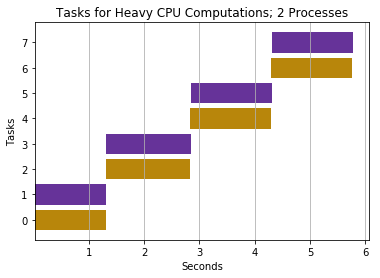

In [91]:
visualize_multiprocessing_effect(number_of_concurrent_processes=2,
                                function_name=sum_all_intgers_from_zero_to_end_range_number,
                                iterable=large_numbers,
                                plot_title="Tasks for Heavy CPU Computations; 2 Processes")

Let's visualize the effect of multiprocessing with 4 concurrent subprocesses.

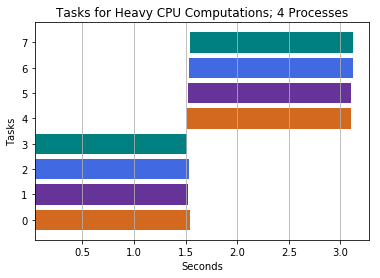

In [92]:
visualize_multiprocessing_effect(number_of_concurrent_processes=4,
                                function_name=sum_all_intgers_from_zero_to_end_range_number,
                                iterable=large_numbers,
                                plot_title="Tasks for Heavy CPU Computations; 4 Processes")

Let's visualize the effect of multiprocessing with 5 concurrent subprocesses. 

The runtime of this program is the same as that of 4 subprocess above. But why? Well, there's no benefit to attempting to use greater than 4 sub-processes for CPU bound tasks because my laptop has just 4 cores - the ability to run a single process concurrently on each core.

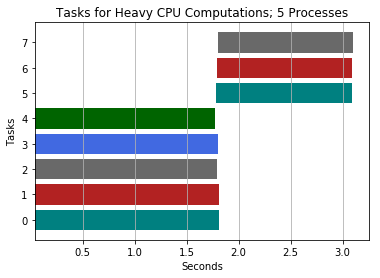

In [93]:
visualize_multiprocessing_effect(number_of_concurrent_processes=5,
                                function_name=sum_all_intgers_from_zero_to_end_range_number,
                                iterable=large_numbers,
                                plot_title="Tasks for Heavy CPU Computations; 5 Processes")

#### Single Program & Thread

In [94]:
%%time

for i in range(iterations):
    sum_all_intgers_from_zero_to_end_range_number(large_number)

CPU times: user 10.9 s, sys: 34.8 ms, total: 11 s
Wall time: 11 s


**Conclusion:** program completes much faster *with* multiprocessing at approximately 4 subprocesses running concurrently.

Multiprocessing here was helpful for this CPU intensive task because we could benefit from using multiple cores and avoid the global interpreter lock.

Interestingly, spinning up additional subprocesses past 4 has no major effect on improving runtime of our program. Notice how the total program runtime with 4 subprocesses is equivalent to the program with 5 subprocesses.

Threads provide no benefit in Python for CPU intensive tasks like these because of the global interpreter lock.